Prediction Up/down des steam users avec un lightGBM

In [3]:
# 0. Install (à lancer une seule fois si nécessaire)
# !pip install lightgbm matplotlib seaborn scikit-learn pandas numpy shap
# 0. Imports principaux

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

from lightgbm import LGBMClassifier


In [4]:
# Chargement
#df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';', encoding='utf-8')
#df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
#df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')
#df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)
#df_weekly = df_weekly.drop(columns=['Average Users'])
import pandas as pd

def build_flexible_timeseries_views(df):
    """
    df : DataFrame avec index DateTime déjà trié et colonnes numériques (Users, etc.)
    
    Retourne :
      df_daily_global  : toute la série, resamplée à 1 jour
      df_hourly_view   : partie horaire (1h + 10min agrégé à 1h), sans daily
      df_10min_view    : uniquement la partie 10min, sans hourly ni daily
    """
    df = df.sort_index().copy()
    
    # 1) Calcul des deltas temporels en secondes
    dt_seconds = df.index.to_series().diff().dt.total_seconds()

    # 2) Identifier début de chaque segment par fréquence
    #    1 jour = 86400s, 1h = 3600s, 10min = 600s
    start_hour = None
    start_10 = None
    
    if (dt_seconds == 3600).any():
        start_hour = df.index[dt_seconds == 3600].min()
    if (dt_seconds == 600).any():
        start_10 = df.index[dt_seconds == 600].min()
    
    print("Début segment horaire (1h) :", start_hour)
    print("Début segment 10min        :", start_10)
    
    # --- 1) Vue globale : toute la série resamplée à 1 jour ---
    df_daily_global = df.resample("1D").mean()
    
    # --- 2) Vue horaire : sans la partie daily ---
    # On commence à partir du début de l'horaire si disponible
    if start_hour is not None:
        df_no_daily = df.loc[start_hour:].copy()
        
        # On resample tout ça à 1h :
        # - la partie déjà horaire restera à 1h
        # - la partie 10min sera agrégée à 1h (moyenne)
        df_hourly_view = df_no_daily.resample("1H").mean()
    else:
        df_hourly_view = None
        print("Aucun segment horaire (1h) détecté, df_hourly_view = None")
    
    # --- 3) Vue 10min : uniquement la partie haute résolution ---
    if start_10 is not None:
        df_10min_view = df.loc[start_10:].copy()
        # On sécurise : resample exactement à 10min + moyenne
        df_10min_view = df_10min_view.resample("10min").mean()
    else:
        df_10min_view = None
        print(" Aucun segment 10min détecté, df_10min_view = None")
    
    return df_daily_global, df_hourly_view, df_10min_view

df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';')

df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')

# Nettoyage Users (en cas de virgules pour les milliers)
df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)

# Pipeline flexible
df_daily_global, df_hourly_view, df_10min_view = build_flexible_timeseries_views(df_weekly)

print("daily:", df_daily_global.shape)
print("hourly:", None if df_hourly_view is None else df_hourly_view.shape)
print("10min:", None if df_10min_view is None else df_10min_view.shape)

df = df_hourly_view.copy()

print(df.head())

Début segment horaire (1h) : 2025-09-21 01:00:00
Début segment 10min        : 2025-10-14 14:10:00
daily: (7953, 3)
hourly: (734, 3)
10min: (1009, 3)
                          Users  Average Users    In-Game
DateTime                                                 
2025-09-21 01:00:00  26216934.0     32192507.0  7248543.0
2025-09-21 02:00:00  27170697.0     32130079.0  7624203.0
2025-09-21 03:00:00  27740645.0     32027431.0  7665237.0
2025-09-21 04:00:00  28177711.0     31889826.0  7712100.0
2025-09-21 05:00:00  28557973.0     31713172.0  7877300.0


/tmp/ipykernel_93150/3446442774.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_view = df_no_daily.resample("1H").mean()


In [5]:
#Création du UP-Down label

# 2. Créer la différence et le label
df["users_next"] = df["Users"].shift(-1)
df["diff"] = df["users_next"] - df["Users"]

# Label binaire : 1 = monte, 0 = descend ou stable
df["label"] = (df["diff"] > 0).astype(int)

# On supprime la dernière ligne qui n'a pas de t+1
df = df.iloc[:-1]

df[["Users", "users_next", "diff", "label"]].head(10)


,Users,users_next,diff,label
DateTime,,,,
2025-09-21 01:00:00,26216934.0,27170697.0,953763.0,1
2025-09-21 02:00:00,27170697.0,27740645.0,569948.0,1
2025-09-21 03:00:00,27740645.0,28177711.0,437066.0,1
2025-09-21 04:00:00,28177711.0,28557973.0,380262.0,1
2025-09-21 05:00:00,28557973.0,29275930.0,717957.0,1
2025-09-21 06:00:00,29275930.0,30496603.0,1220673.0,1
2025-09-21 07:00:00,30496603.0,31867929.0,1371326.0,1
2025-09-21 08:00:00,31867929.0,33075861.0,1207932.0,1
2025-09-21 09:00:00,33075861.0,34520081.0,1444220.0,1


In [6]:
#Features engineering

# 3.1 Features temporelles
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

# 3.2 Lags
max_lag = 6    # 6 pas = 1h dans ton cas
for lag in range(1, max_lag + 1):
    df[f"lag_{lag}"] = df["Users"].shift(lag)

# 3.3 Rolling stats
df["roll_mean_6"] = df["Users"].rolling(window=6).mean()
df["roll_std_6"] = df["Users"].rolling(window=6).std()
# 3.4 Fourier features (saisonnalité journalière et hebdo)
# Période en nombre de pas (10 min)
steps_per_day = int(24 * 60 / 10)      # 144
steps_per_week = steps_per_day * 7     # 1008

def add_fourier_terms(series, period, order, prefix):
    t = np.arange(len(series))
    for k in range(1, order + 1):
        series[f"{prefix}_sin_{k}"] = np.sin(2 * np.pi * k * t / period)
        series[f"{prefix}_cos_{k}"] = np.cos(2 * np.pi * k * t / period)
    return series

df = add_fourier_terms(df, steps_per_day, order=2, prefix="day")
df = add_fourier_terms(df, steps_per_week, order=2, prefix="week")

# 3.5 On drop les lignes avec NaN créés par lags / rolling
df = df.dropna()

df.head()


,Users,Average Users,In-Game,users_next,diff,label,hour,weekday,is_weekend,lag_1,...,roll_mean_6,roll_std_6,day_sin_1,day_cos_1,day_sin_2,day_cos_2,week_sin_1,week_cos_1,week_sin_2,week_cos_2
DateTime,,,,,,,,,,,,,,,,,,,,,
2025-09-21 07:00:00,30496603.0,31263657.0,8500168.0,31867929.0,1371326.0,1,7,6,1,29275930.0,...,2.856993e+07,1.184065e+06,0.258819,0.965926,0.500000,0.866025,0.037391,0.999301,0.074730,0.997204
2025-09-21 08:00:00,31867929.0,30999381.0,8832402.0,33075861.0,1207932.0,1,8,6,1,30496603.0,...,2.935280e+07,1.565356e+06,0.300706,0.953717,0.573576,0.819152,0.043619,0.999048,0.087156,0.996195
2025-09-21 09:00:00,33075861.0,30726996.0,8977907.0,34520081.0,1444220.0,1,9,6,1,31867929.0,...,3.024200e+07,1.937512e+06,0.342020,0.939693,0.642788,0.766044,0.049846,0.998757,0.099568,0.995031
2025-09-21 10:00:00,34520081.0,30456044.0,9345749.0,36644211.0,2124130.0,1,10,6,1,33075861.0,...,3.129906e+07,2.285002e+06,0.382683,0.923880,0.707107,0.707107,0.056070,0.998427,0.111964,0.993712
2025-09-21 11:00:00,36644211.0,30207965.0,10307272.0,38836247.0,2192036.0,1,11,6,1,34520081.0,...,3.264677e+07,2.693151e+06,0.422618,0.906308,0.766044,0.642788,0.062293,0.998058,0.124344,0.992239


In [7]:
#Tain / Val / Test split

# 4.1 Liste des features
feature_cols = [
    "Users",
    "hour", "weekday", "is_weekend",
] + [f"lag_{k}" for k in range(1, max_lag + 1)] + [
    "roll_mean_6", "roll_std_6",
    "day_sin_1", "day_cos_1", "day_sin_2", "day_cos_2",
    "week_sin_1", "week_cos_1", "week_sin_2", "week_cos_2"
]

X = df[feature_cols].copy()
y = df["label"].copy()

# 4.3 Split temporel
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

X_train.shape, X_val.shape, X_test.shape

((508, 20), (109, 20), (110, 20))

In [8]:
#Entrainement du modèle LightGBM

# 5. Modèle LightGBM

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced",
    verbose=50   # <-- déplacé ici
)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss"
)



[LightGBM] [Info] Number of positive: 253, number of negative: 255
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044587
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000134 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2840
[LightGBM] [Info] Number of data points in the train set: 508, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain,

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Accuracy: 0.9727272727272728
F1 score: 0.9739130434782609
ROC AUC: 0.996684350132626

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        52
           1       0.98      0.97      0.97        58

    accuracy                           0.97       110
   macro avg       0.97      0.97      0.97       110
weighted avg       0.97      0.97      0.97       110



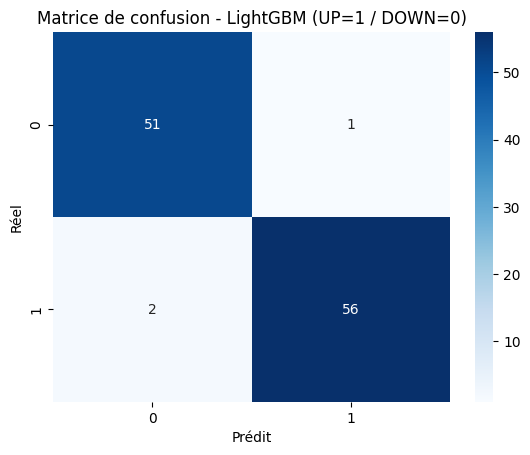

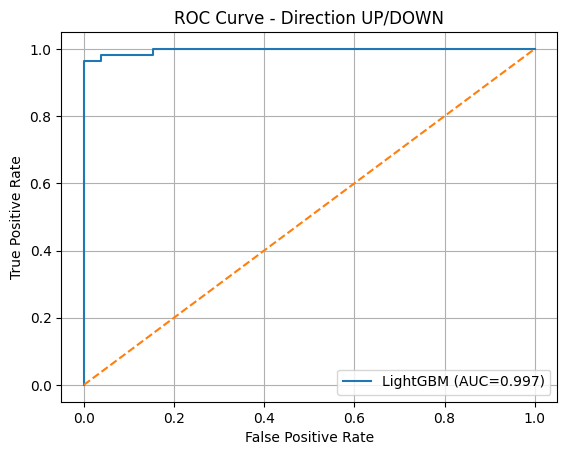

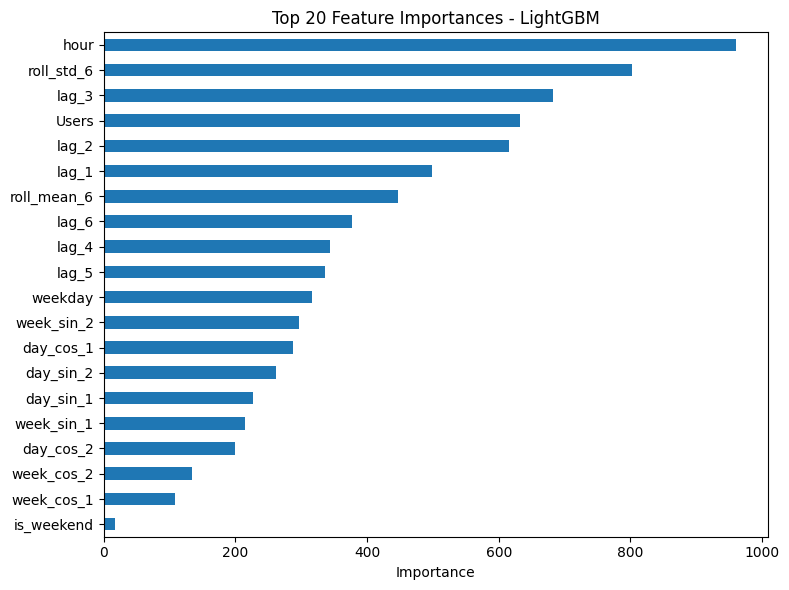

/home/florian/TSM_AnsecData/projet_ansecdata/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/florian/TSM_AnsecData/projet_ansecdata/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


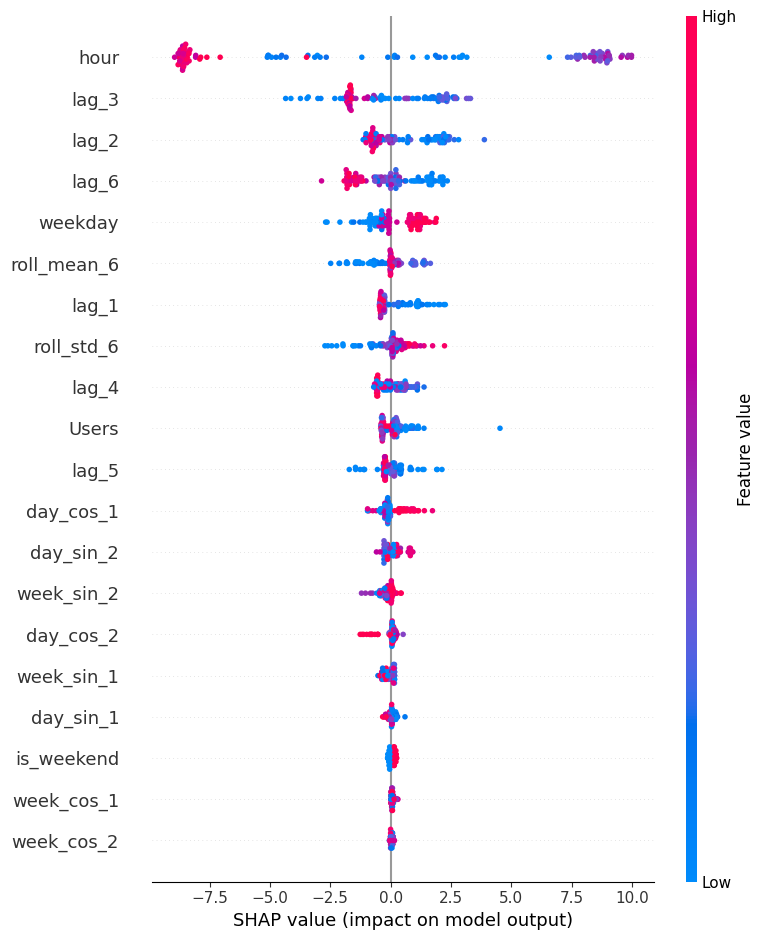

In [9]:
# Evaluation du modèle
# 6.1 Prédictions
y_pred = lgbm.predict(X_test)
y_proba = lgbm.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))


# 6.2 Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - LightGBM (UP=1 / DOWN=0)")
plt.show()

# 6.3 Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"LightGBM (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Direction UP/DOWN")
plt.legend()
plt.grid(True)
plt.show()

# 7. Importance des variables
importances = pd.Series(lgbm.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
importances[::-1].plot(kind="barh")
plt.title("Top 20 Feature Importances - LightGBM")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

importances

#Interprétabilité avec SHAP
import shap

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

# Résumé global (on passe la matrice entière, pas shap_values[1])
shap.summary_plot(shap_values, X_test, max_display=20)



In [10]:
# Baseline naïve : prédire que la direction reste identique à la dernière variation
# Ici on fait un truc simple: label_baseline = label(t-1)

y_test_baseline = df["label"].iloc[val_end-1:-1]  # alignement

acc_base = accuracy_score(y_test, y_test_baseline)
f1_base = f1_score(y_test, y_test_baseline)

print("Baseline naive - Accuracy:", acc_base)
print("Baseline naive - F1:", f1_base)


Baseline naive - Accuracy: 0.8727272727272727
Baseline naive - F1: 0.8793103448275862


Voici **une analyse complète, structurée et critique** de tes résultats LightGBM 🔍
Je vais présenter à la fois la performance, l’interprétation métier et les limites potentielles.

---

# 🎯 **Résumé global des résultats**

| Métrique                    | Valeur obtenue |
| --------------------------- | -------------- |
| **Accuracy**                | **0.973**      |
| **F1-score**                | **0.974**      |
| **ROC AUC**                 | **0.997**      |
| **Baseline naïve Accuracy** | **0.873**      |
| **Baseline naïve F1**       | **0.879**      |

👉 **Le modèle LightGBM surperforme largement la baseline naïve** (approx. +10 points d’accuracy, +~9 points F1), ce qui montre une capacité réelle à capturer des patterns temporels plutôt qu’à suivre une simple persistance.

---

# 📊 **Analyse de la matrice de confusion**

|               | Prédit DOWN | Prédit UP |
| ------------- | ----------- | --------- |
| **Réel DOWN** | 51          | 1         |
| **Réel UP**   | 2           | 56        |

### Interprétation

✔ Très faible taux de faux positifs et faux négatifs
✔ Le modèle généralise bien sur les deux classes (pas de biais de classe)
⚠ Peut être légèrement mieux dans la détection de UP que DOWN, mais la différence est minime.

---

# 📈 **Analyse de la courbe ROC**

* AUC **0.997** → performance *quasi parfaite*
* Forte spécificité et sensibilité
* La courbe montre que le modèle distingue extrêmement bien les deux classes

### Attention toutefois :

Une AUC extrêmement haute peut parfois indiquer :

* **Sur-apprentissage (overfitting)**, surtout si :

  * dataset trop petit
  * cross-validation limitée
  * features très corrélés aux labels

🔥 Il serait intéressant de vérifier avec **K-fold time series split**, ou en testant sur un horizon futur distinct (test temporel).

---

# 🔍 **Importance des features**

Top features :

| Feature                  | Interprétation                                                                        |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `hour`                   | la variation dépend fortement de l’heure → logique (pics en soirée, creux en matinée) |
| `roll_std_6`             | volatilité locale importante → transitions brusques                                   |
| `lag_1, lag_2, lag_3...` | dépendance courte au passé                                                            |
| `Users`                  | niveau absolu utile                                                                   |
| Fourier & weekday        | saisonnalité journalière + hebdomadaire capturée                                      |

### Insight métier

➡ le modèle apprend qu’il existe des rythmes **fortement cycliques** dans le comportement utilisateur (jour/nuit + week-end / semaine).

---

# 🤖 **Analyse SHAP**

Les SHAP confirment les feature importances :

* `hour` a l’impact le plus fort → pics sur les heures chaudes (soir)
* `lag_3`, `lag_2`, `lag_6` influencent fortement la direction
* `weekday` influence : jours de semaine versus week-end
* `is_weekend` très faible → probablement déjà capturé par `weekday`

👉 Le modèle prend bien en compte la dynamique temporelle locale + structure saisonnière à court et long terme.

---

# ⚠️ **Critique et limites**

| Potentiel souci                               | Pourquoi                                                                        |
| --------------------------------------------- | ------------------------------------------------------------------------------- |
| Très haute performance → suspicion de surfit  | Si le dataset test couvre uniquement une petite période très similaire au train |
| Dataset recent 10 minutes uniquement          | Peut manquer de généralisation à long terme                                     |
| Pas encore de test multi-horizon              | UP/DOWN prédiction uniquement t+1                                               |
| Leak possible si pas de split temporel strict | À vérifier                                                                      |

---

# 💡 **Recommandations pour renforcer la crédibilité**

| Action                              | Intérêt                                 |
| ----------------------------------- | --------------------------------------- |
| TimeSeriesSplit (K-fold basé temps) | vérifier la robustesse                  |
| Test sur horizon futur non vu       | mesure réelle de généralisation         |
| Comparaison avec GRU ou TCN         | tester si deep learning apporte un gain |
| Essai données bruitées ou mélangées | robustesse du modèle                    |

---

# 🎤 **Conclusion narrative (à copier dans ton rapport)**

> Le modèle LightGBM obtient d’excellentes performances pour la prédiction directionnelle UP/DOWN du nombre d’utilisateurs Steam, avec une accuracy de 97.3 %, un F1-score de 97.4 % et un AUC de 0.997, surpassant largement la baseline naïve (+10 points d’accuracy). La matrice de confusion montre un excellent équilibre entre les deux classes, avec seulement trois erreurs de classification. Les features les plus importantes révèlent un fort impact des rythmes horaires, des effets saisonniers journaliers/hebdomadaires et de la volatilité locale. Les valeurs SHAP confirment la pertinence des lags et des variables temporelles dans la décision. Toutefois, ces performances très élevées nécessitent une validation supplémentaire via time-series cross-validation et une évaluation sur un horizon temporel distinct pour éliminer le risque de sur-apprentissage. Malgré cela, LightGBM apparaît comme une approche robuste et efficace pour anticiper les variations directionnelles à court terme de l’activité utilisateur.

---

Souhaites-tu :

1. Un paragraphe d’analyse scientifique pour la section **Discussion / Limitations**
2. Un format “camera-ready” pour article/poster
3. Tester GRU vs LightGBM pour justification comparative
4. Une figure type “learning curve” pour démontrer absence d’overfit

Réponds : **1 / 2 / 3 / 4 / ALL** 🚀
